In [1]:
import shutil
import os
from pathlib import Path
import subprocess
import time
import seaborn as sns
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib import cm
import matplotlib.pyplot as plt
import math
import re
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
from collections import defaultdict 

mpl.rcParams['figure.dpi'] = 400


def geo_mean(iterable):
    a = np.array(iterable) + 1
    return (a.prod()**(1.0/len(a))) - 1

def harmonic_mean(a):
    return (len(a) / np.sum(1.0/(1 + a))) - 1

# preferred_colors = ["#5588dd", "#882255", "#33bb88",
#                     "#ddcc77", "#cc6677", "#999933", "#aa44ff", "#448811"]


plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels

colors = {
    "Embench": "#0075ab",
    "GAP": "#aa6fc5",
    "NAS": "#ff6583",
    "SPEC2017": "#ffa600",
    "ALL": "#54EE2E", # Bright green!
}


rename_table = {
    'sglib-combined': 'sglib',

}


def format_xtick(tick):
    tick = re.sub('^\\d+.', '', tick)
    tick = re.sub('_s$', '', tick)
    if tick in rename_table:
        return rename_table[tick]
    return tick


def do_pivot(df, metric):
    df = df.pivot_table(index=['suite', 'benchmark'],
                        columns='config', values=metric).reset_index()
    df['key'] = df['suite'] + '@' + df['benchmark']
    return df


def plot_metric(df, output, metric, title='Result', ylabel='speedup', figsize=(9, 2.8), show_values=False, geomean_parts=False, geomean_all=True):
    bars = {
        'benchmark': [],
        'suite': [],
        ylabel: [],
    }


    suites = defaultdict(lambda: {'benchmark': [], ylabel: []})

    def add_bar(bench, suite, value):
        bars['benchmark'].append(suite + '@' + bench)
        bars['suite'].append(suite)
        bars[ylabel].append(value)

        suites[suite]['benchmark'].append(suite + '@' + bench)
        suites[suite][ylabel].append(value)


    for name, group in df.groupby('suite'):
        for _, row in group.iterrows():
            add_bar(row['benchmark'], row['suite'], row[ylabel])
        if geomean_parts:
            add_bar('geomean', name, geo_mean(group[ylabel]))
        # add_bar('harmonic mean', name, harmonic_mean(group[ylabel]))

    if geomean_all:
        geo = geo_mean(df[ylabel])
        add_bar('geomean', 'ALL', geo_mean(df[ylabel]))
    df = pd.DataFrame(bars)

    f, ax = plt.subplots(1, figsize=figsize)
    plt.grid(axis='y')


    g = sns.barplot(data=df,
                    x='benchmark',
                    y=ylabel,
                    hue='suite',
                    linewidth=1,
                    edgecolor='black',
                    palette=colors,
                    ax=ax,
                    dodge=False)


    max_val = max(df[ylabel])
    min_val = min(df[ylabel])
    top = max_val * 1.2
    bottom = min(0, min_val * 1.2)
    g.set_ylim((bottom, top))

    g.set_xticklabels(map(lambda x: format_xtick(x.split(
        '@')[1]), (item.get_text() for item in g.get_xticklabels())))

    # Hide legend
    plt.legend([],[], frameon=False)

    plt.axhline(y=0, linewidth=1, color='black')

    for _, hue in enumerate(df['suite'].unique()[:-1]):
        xpos = df.loc[df['suite'] == hue].index[-1] + 0.5
        plt.axvline(x=xpos, linewidth=1, color='black')


    for name, group in df.groupby('suite'):
        xpos = max(0, np.mean(group['benchmark'].index))
        ypos = top
        a = plt.text(
            xpos,
            ypos,
            name,
            ha='center',
            va='bottom',
            fontsize=10,  # You can adjust the fontsize as needed
            # fontweight='bold'  # You can specify other font properties as well
        )


    for x, row in df.iterrows():
        y = row[ylabel] + 0.0

        perc = y * 100
        g.annotate(f'{perc:.1f}',
                   (x, max(y, 0)),
                   ha='center',
                   va='bottom',
                   xytext=(0, 1),
                   fontsize=6.5,
                   # fontweight='bold',
                   rotation=0,
                   textcoords='offset points',
                   zorder=11)

    g.set(title=None)
    g.set(xlabel=None)
    g.set(ylabel=ylabel)
    plt.grid(visible=True, which='minor', linestyle='-', alpha=0.2, zorder=1)
    ax.set_axisbelow(True)

    plt.tight_layout()

    return g, plt, df




def plot_overhead(df, output, metric, baseline, modified, title='Result', ylabel='overhead', figsize=(9, 2.5), show_values=False, geomean_parts=True, geomean_all=True, angle_dude=65):
    df = do_pivot(df, metric)
    df[ylabel] = (df[modified] - df[baseline]) / df[baseline]
    g, plt, df = plot_metric(df, output, 'overhead', title=title, geomean_parts=geomean_parts, geomean_all=geomean_all,
                         ylabel=ylabel, figsize=figsize, show_values=show_values)
    file = '../figs/plots/' + output
    # g.set_ylim((0, 1.1))
    # plt.xticks(rotation=90)
    plt.xticks(rotation=angle_dude, fontsize=7, rotation_mode='anchor', ha='right')

    g.yaxis.set_major_formatter(
        mtick.FuncFormatter(lambda y, _: '{}%'.format(int(y * 100))))

    labels = plt.gca().get_xticklabels()
    offset = 0.025

    plt.tight_layout()
    # plt.savefig(file, bbox_inches = 'tight', pad_inches = .05)
    plt.show()
    print()


,suite,benchmark,config,time,stime,utime,major,minor,maxrss,status
0,Embench,matmult-int,baseline,2.079980,0.000000,2.079980,0,130,71076,0
1,Embench,matmult-int,baseline,2.079030,0.000000,2.079030,0,130,70980,0
2,Embench,matmult-int,baseline,2.083842,0.000000,2.083842,0,130,70984,0
3,Embench,matmult-int,baseline,2.085063,0.000000,2.085063,0,130,70984,0
4,Embench,matmult-int,baseline,2.082786,0.000000,2.082786,0,130,70984,0
...,...,...,...,...,...,...,...,...,...,...
559,SPEC2017,644.nab_s,alaska,1805.624189,0.163983,1805.460206,0,143650,574700,0
560,SPEC2017,644.nab_s,alaska,1806.658322,0.267974,1806.390348,0,143650,574700,0
561,SPEC2017,644.nab_s,alaska,1808.194119,0.199980,1807.994139,0,143650,574700,0
562,SPEC2017,644.nab_s,alaska,1804.458621,0.195980,1804.262641,0,143650,574700,0


/tmp/ipykernel_306891/1522910678.py:117: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(map(lambda x: format_xtick(x.split(


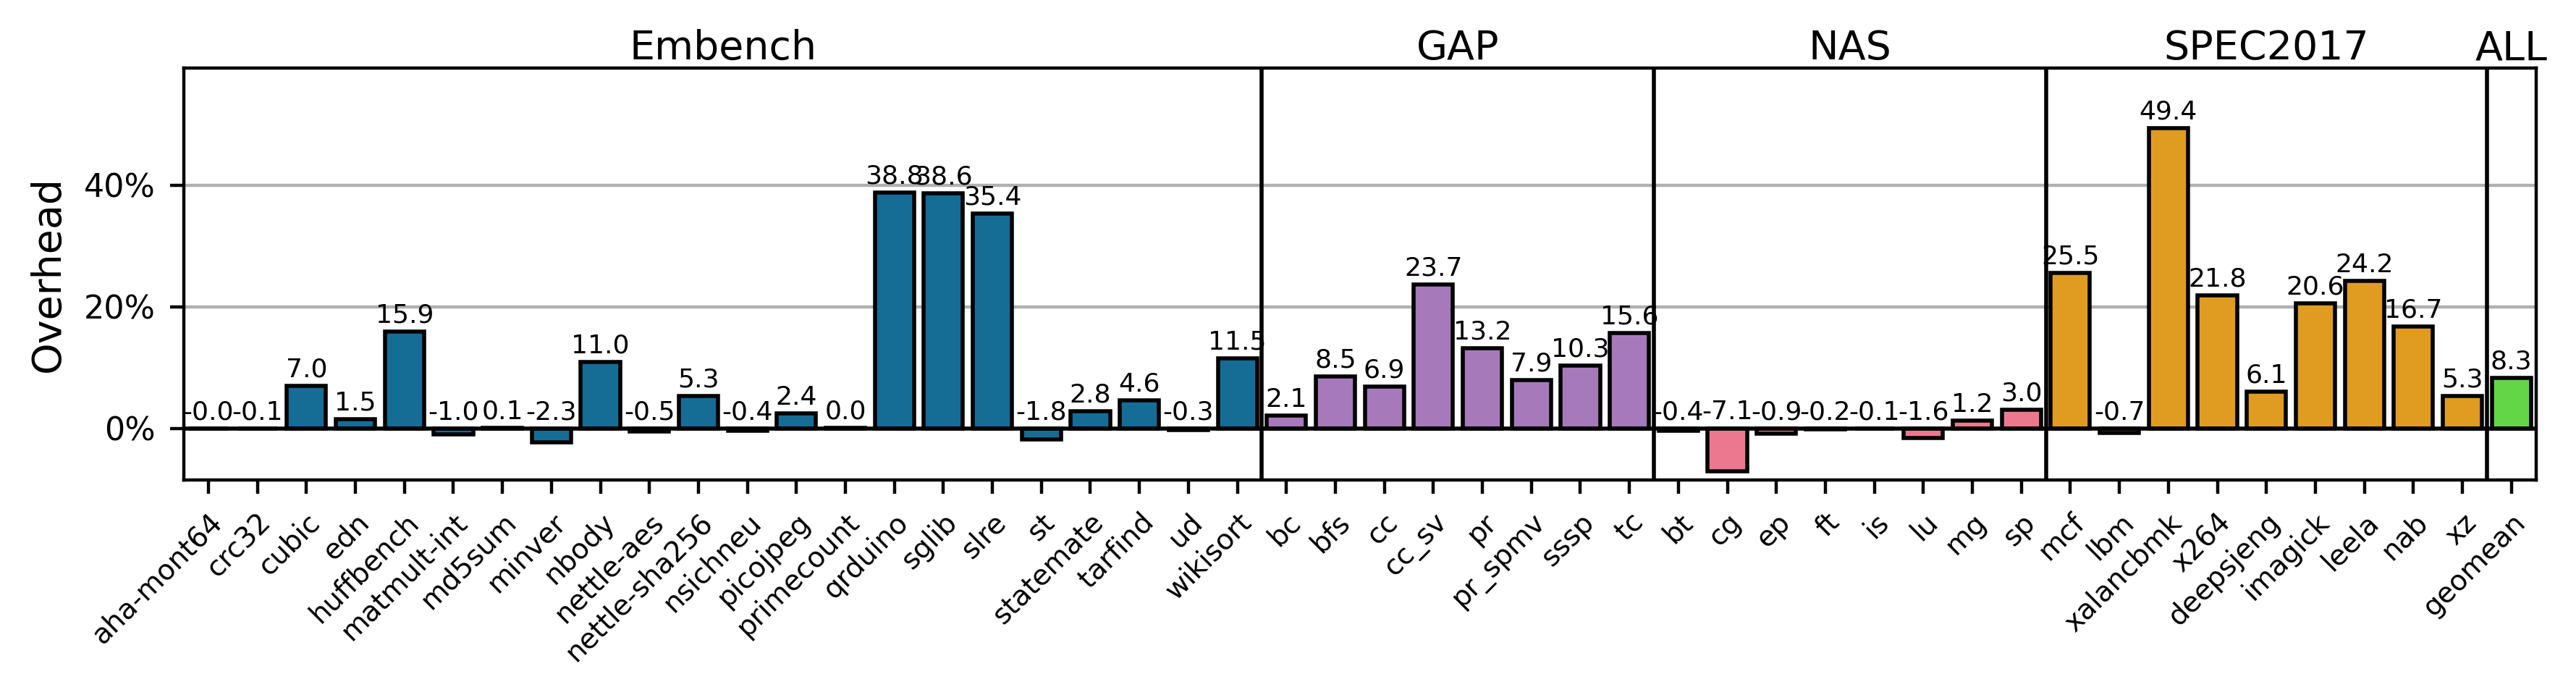

In [2]:
df = pd.read_csv('../results/dec-8-first-run-with-new-tracking.csv')
# df = df[df['suite'] != 'Embench']
display(df)
plot_overhead(df,
              title='Overhead (Lower is better)',
              output='overhead.pdf',
              metric='time',
              baseline='baseline',
              modified='alaska',
              geomean_parts=False,
              figsize=(9, 2.5),
              angle_dude=45,
              ylabel='Overhead')